In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import pickle

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense,Conv2D,Flatten,MaxPool2D,Dropout,BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


In [2]:
# constants
IMG_SIZE = 28
N_CHANNELS = 1 # because gray scale images

In [3]:
train_df = pd.read_csv('/kaggle/input/Kannada-MNIST/train.csv')
test_df = pd.read_csv('/kaggle/input/Kannada-MNIST/Dig-MNIST.csv')
pred_df = pd.read_csv('/kaggle/input/Kannada-MNIST/test.csv')

In [4]:
train_df = train_df.append(test_df)

In [5]:
train_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
print (f'Training set: {train_df.shape}')
print (f'To be Predicted: {pred_df.shape}')

Training set: (70240, 785)
To be Predicted: (5000, 785)


In [7]:
X_train = train_df.drop(['label'], axis = 1)
Y_train = train_df['label']
X_pred = pred_df.drop(['id'], axis = 1)

In [8]:
X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size=0.15)

In [9]:
X_train, X_test, X_pred = X_train.apply(lambda x: x/255), X_test.apply(lambda x: x/255), X_pred.apply(lambda x: x/255)

In [10]:
Y_train, Y_test = pd.get_dummies(Y_train), pd.get_dummies(Y_test)

In [11]:
X_train = X_train.values.reshape(-1, IMG_SIZE, IMG_SIZE, N_CHANNELS)
X_test = X_test.values.reshape(-1, IMG_SIZE, IMG_SIZE, N_CHANNELS)
X_pred = X_pred.values.reshape(-1, IMG_SIZE, IMG_SIZE, N_CHANNELS)

In [12]:
print (f'Training images: {X_train.shape}')
print (f'Testing images: {X_test.shape}')

Training images: (59704, 28, 28, 1)
Testing images: (10536, 28, 28, 1)


In [13]:
Y_train = Y_train.to_numpy()

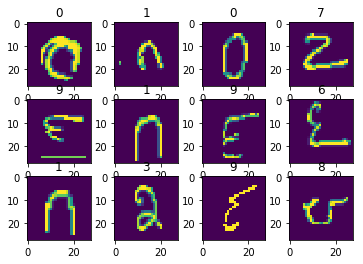

In [14]:
fig, ax = plt.subplots(nrows=3, ncols=4)
count=0
for row in ax:
    for col in row:
        col.set_title(np.argmax(Y_train[count, :]))
        col.imshow(X_train[count, :, :, 0])
        count += 1
plt.show()

In [15]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.15, # Randomly zoom image 
        width_shift_range=0.15,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.15,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


# This will just calculate parameters required to augment the given data. This won't perform any augmentations
datagen.fit(X_train)

In [16]:
models = [0] * 4 # Model array to store different types of CNN architectures

for model_type in range(len(models)):
    models[model_type] = Sequential()
    models[model_type].add(Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu', input_shape=(28, 28, 1)))
    models[model_type].add(MaxPool2D(pool_size=(2, 2)))
    models[model_type].add(BatchNormalization(momentum=0.15))
    if model_type > 0:
        models[model_type].add(Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu'))
        models[model_type].add(MaxPool2D(pool_size=(2, 2)))
        models[model_type].add(BatchNormalization(momentum=0.15))
    elif model_type > 1:
        models[model_type].add(Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu'))
        models[model_type].add(MaxPool2D(pool_size=(2, 2)))
        models[model_type].add(BatchNormalization(momentum=0.15))
    elif model_type > 2:
        models[model_type].add(Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu'))
        models[model_type].add(MaxPool2D(pool_size=(2, 2)))
        models[model_type].add(BatchNormalization(momentum=0.15))
    models[model_type].add(Flatten())
    models[model_type].add(Dense(128, activation = "relu"))
    models[model_type].add(Dense(10, activation = "softmax"))

In [17]:
# Compile all the models
for model_type in range(len(models)):
    models[model_type].compile(optimizer="adam", loss=['categorical_crossentropy'], metrics=['accuracy'])

In [18]:
# Set a learning rate annealer. Learning rate will be half after 3 epochs if accuracy is not increased
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1,
                                            factor=0.5, 
                                            min_lr=0.00001)

In [19]:
batch_size=32
epochs = 25

In [20]:
histories = [0] * len(models)
for model_type in range(len(models)):
    # Fit the models
    print (f'### Training model # {model_type}')
    histories[model_type] = models[model_type].fit_generator(datagen.flow(X_train, Y_train, batch_size=batch_size),
                                  epochs = epochs, validation_data = (X_test,Y_test),
                                  steps_per_epoch=X_train.shape[0] // batch_size, 
                                  callbacks=[learning_rate_reduction])

### Training model # 0
Epoch 1/25
1865/1865 [==============================] - 25s 14ms/step - loss: 0.3074 - accuracy: 0.9057 - val_loss: 0.1269 - val_accuracy: 0.9629
Epoch 2/25
1865/1865 [==============================] - 22s 12ms/step - loss: 0.1581 - accuracy: 0.9515 - val_loss: 0.1165 - val_accuracy: 0.9670
Epoch 3/25
1865/1865 [==============================] - 22s 12ms/step - loss: 0.1368 - accuracy: 0.9592 - val_loss: 0.0884 - val_accuracy: 0.9735
Epoch 4/25
1865/1865 [==============================] - 23s 12ms/step - loss: 0.1182 - accuracy: 0.9646 - val_loss: 0.0852 - val_accuracy: 0.9770
Epoch 5/25
1865/1865 [==============================] - 22s 12ms/step - loss: 0.1087 - accuracy: 0.9678 - val_loss: 0.0863 - val_accuracy: 0.9748
Epoch 6/25
1865/1865 [==============================] - 22s 12ms/step - loss: 0.1033 - accuracy: 0.9684 - val_loss: 0.0744 - val_accuracy: 0.9777
Epoch 7/25
1865/1865 [==============================] - 22s 12ms/step - loss: 0.0997 - accuracy: 0.96

In [21]:
for model_type in range(len(models)):
    models[model_type].save(f'model_{model_type}.h5')

In [22]:
for i in range(len(models)):
    with open(f'his{i}.pkl', 'wb') as output:
        pickle.dump(histories[i], output, pickle.HIGHEST_PROTOCOL)

In [23]:
%matplotlib inline
def PlotLoss(histories, epochs, is_training):
    plt.style.use("ggplot")
    plt.figure()
    for i in range(len(histories)):
        if is_training:
            plt.plot(np.arange(0, epochs), histories[i].history["loss"], label=f"train_loss_{i}")
            plt.title("Training Loss")
        else:
            plt.plot(np.arange(0, epochs), histories[i].history["val_loss"], label=f"val_loss_{i}")
            plt.title("Validation Loss")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss")
    plt.legend(loc="upper right")
    plt.show()

def PlotAcc(histories, epochs, is_training):
    plt.style.use("ggplot")
    plt.figure()
    for i in range(len(histories)):
        if is_training:
            plt.plot(np.arange(0, epochs), histories[i].history["accuracy"], label=f"train_acc_{i}")
            plt.title("Training Accuracy")
        else:
            plt.plot(np.arange(0, epochs), histories[i].history["val_accuracy"], label=f"val_acc_{i}")
            plt.title("Validation Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Accuracy")
    plt.legend(loc="lower right")
    plt.show()

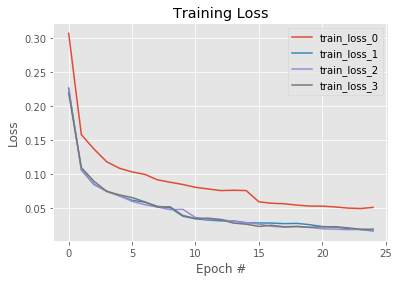

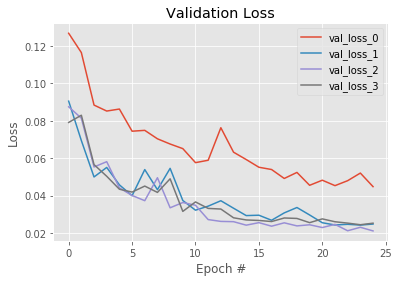

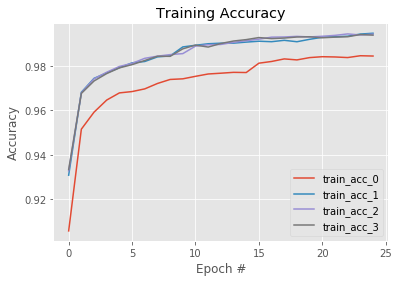

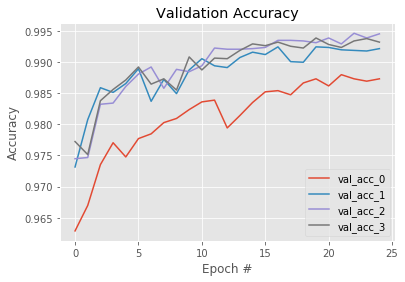

In [24]:
PlotLoss(histories, epochs, True)
PlotLoss(histories, epochs, False)
PlotAcc(histories, epochs, True)
PlotAcc(histories, epochs, False)

### Model #2 seems promising. Now search for number of filters in each convolutional layer

In [25]:
models = [0] * 4 # Model array to store different types of CNN architectures

for model_type in range(len(models)):
    models[model_type] = Sequential()
    
    models[model_type].add(Conv2D(filters=2**(model_type + 3), kernel_size=(3, 3), padding='SAME', activation='relu', input_shape=(28, 28, 1)))
    models[model_type].add(MaxPool2D(pool_size=(2, 2)))
    models[model_type].add(BatchNormalization(momentum=0.15))
    
    models[model_type].add(Conv2D(filters=2**(model_type + 4), kernel_size=(3, 3), padding='SAME', activation='relu'))
    models[model_type].add(MaxPool2D(pool_size=(2, 2)))
    models[model_type].add(BatchNormalization(momentum=0.15))
    
    models[model_type].add(Conv2D(filters=2**(model_type + 5), kernel_size=(3, 3), padding='SAME', activation='relu'))
    models[model_type].add(MaxPool2D(pool_size=(2, 2)))
    models[model_type].add(BatchNormalization(momentum=0.15))
    
    models[model_type].add(Flatten())
    models[model_type].add(Dense(128, activation = "relu"))
    
    models[model_type].add(Dense(10, activation = "softmax"))

In [26]:
# Compile all the models
for model_type in range(len(models)):
    models[model_type].compile(optimizer="adam", loss=['categorical_crossentropy'], metrics=['accuracy'])

In [27]:
# Set a learning rate annealer. Learning rate will be half after 3 epochs if accuracy is not increased
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1,
                                            factor=0.5, 
                                            min_lr=0.00001)

In [28]:
batch_size=32
epochs = 25

In [29]:
histories = [0] * len(models)
for model_type in range(len(models)):
    # Fit the models
    print (f'### Training model # {model_type}')
    histories[model_type] = models[model_type].fit_generator(datagen.flow(X_train, Y_train, batch_size=batch_size),
                                  epochs = epochs, validation_data = (X_test,Y_test),
                                  steps_per_epoch=X_train.shape[0] // batch_size, 
                                  callbacks=[learning_rate_reduction])

### Training model # 0
Epoch 1/25
1865/1865 [==============================] - 26s 14ms/step - loss: 0.2651 - accuracy: 0.9164 - val_loss: 0.0997 - val_accuracy: 0.9719
Epoch 2/25
1865/1865 [==============================] - 26s 14ms/step - loss: 0.1108 - accuracy: 0.9649 - val_loss: 0.0956 - val_accuracy: 0.9707
Epoch 3/25
1865/1865 [==============================] - 25s 14ms/step - loss: 0.0901 - accuracy: 0.9715 - val_loss: 0.0658 - val_accuracy: 0.9820
Epoch 4/25
1865/1865 [==============================] - 25s 13ms/step - loss: 0.0776 - accuracy: 0.9763 - val_loss: 0.0507 - val_accuracy: 0.9834
Epoch 5/25
1865/1865 [==============================] - 25s 14ms/step - loss: 0.0722 - accuracy: 0.9781 - val_loss: 0.0547 - val_accuracy: 0.9822
Epoch 6/25
1865/1865 [==============================] - 25s 13ms/step - loss: 0.0651 - accuracy: 0.9799 - val_loss: 0.0492 - val_accuracy: 0.9860
Epoch 7/25
1865/1865 [==============================] - 25s 14ms/step - loss: 0.0588 - accuracy: 0.98

In [30]:
for model_type in range(len(models)):
    models[model_type].save(f'model_{model_type}.h5')

In [31]:
for i in range(len(models)):
    with open(f'his{i}.pkl', 'wb') as output:
        pickle.dump(histories[i], output, pickle.HIGHEST_PROTOCOL)

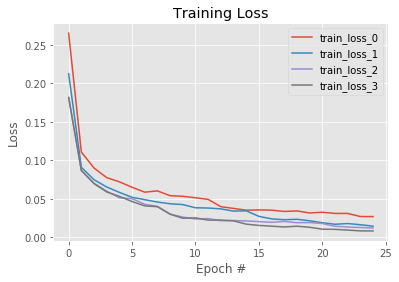

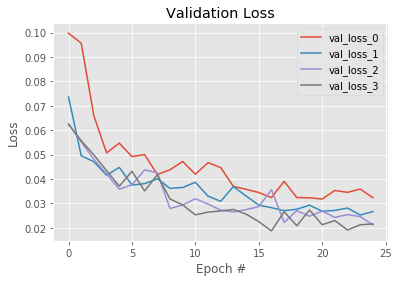

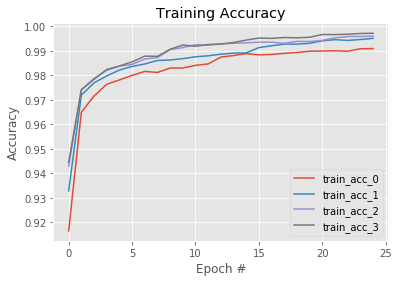

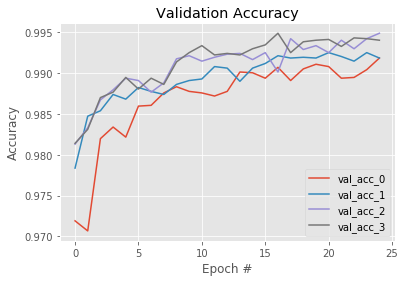

In [32]:
PlotLoss(histories, epochs, True)
PlotLoss(histories, epochs, False)
PlotAcc(histories, epochs, True)
PlotAcc(histories, epochs, False)

### Model #2 seems promising. Filter sizes: 32, 64 and 128. Now search for better size of fully connected layer

In [33]:
models = [0] * 6 # Model array to store different types of CNN architectures

for model_type in range(len(models)):
    models[model_type] = Sequential()
    
    models[model_type].add(Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu', input_shape=(28, 28, 1)))
    models[model_type].add(MaxPool2D(pool_size=(2, 2)))
    models[model_type].add(BatchNormalization(momentum=0.15))
    
    models[model_type].add(Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu'))
    models[model_type].add(MaxPool2D(pool_size=(2, 2)))
    models[model_type].add(BatchNormalization(momentum=0.15))
    
    models[model_type].add(Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu'))
    models[model_type].add(MaxPool2D(pool_size=(2, 2)))
    models[model_type].add(BatchNormalization(momentum=0.15))
    
    models[model_type].add(Flatten())
    models[model_type].add(Dense(2**(model_type + 5), activation = "relu"))
    
    models[model_type].add(Dense(10, activation = "softmax"))

In [34]:
# Compile all the models
for model_type in range(len(models)):
    models[model_type].compile(optimizer="adam", loss=['categorical_crossentropy'], metrics=['accuracy'])

In [35]:
# Set a learning rate annealer. Learning rate will be half after 3 epochs if accuracy is not increased
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1,
                                            factor=0.5, 
                                            min_lr=0.00001)

In [36]:
batch_size=32
epochs = 25

In [37]:
histories = [0] * len(models)
for model_type in range(len(models)):
    # Fit the models
    print (f'### Training model # {model_type}')
    histories[model_type] = models[model_type].fit_generator(datagen.flow(X_train, Y_train, batch_size=batch_size),
                                  epochs = epochs, validation_data = (X_test,Y_test),
                                  steps_per_epoch=X_train.shape[0] // batch_size, 
                                  callbacks=[learning_rate_reduction])

### Training model # 0
Epoch 1/25
1865/1865 [==============================] - 26s 14ms/step - loss: 0.2022 - accuracy: 0.9383 - val_loss: 0.0678 - val_accuracy: 0.9804
Epoch 2/25
1865/1865 [==============================] - 26s 14ms/step - loss: 0.0962 - accuracy: 0.9705 - val_loss: 0.0628 - val_accuracy: 0.9819
Epoch 3/25
1865/1865 [==============================] - 26s 14ms/step - loss: 0.0727 - accuracy: 0.9778 - val_loss: 0.0477 - val_accuracy: 0.9855
Epoch 4/25
1865/1865 [==============================] - 25s 14ms/step - loss: 0.0618 - accuracy: 0.9811 - val_loss: 0.0441 - val_accuracy: 0.9862
Epoch 5/25
1865/1865 [==============================] - 25s 14ms/step - loss: 0.0580 - accuracy: 0.9821 - val_loss: 0.0448 - val_accuracy: 0.9875
Epoch 6/25
1865/1865 [==============================] - 26s 14ms/step - loss: 0.0517 - accuracy: 0.9836 - val_loss: 0.0394 - val_accuracy: 0.9883
Epoch 7/25
1865/1865 [==============================] - 26s 14ms/step - loss: 0.0484 - accuracy: 0.98

In [38]:
for model_type in range(len(models)):
    models[model_type].save(f'model_{model_type}.h5')
    with open(f'his{model_type}.pkl', 'wb') as output:
        pickle.dump(histories[model_type], output, pickle.HIGHEST_PROTOCOL)

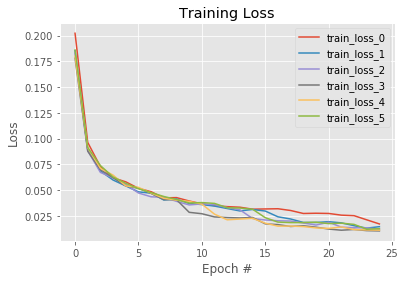

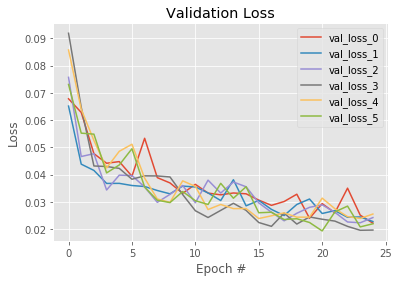

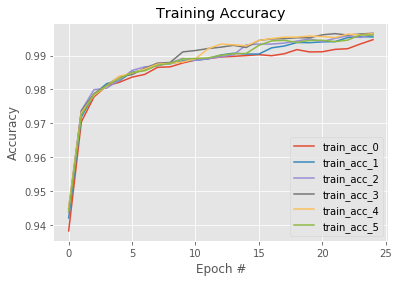

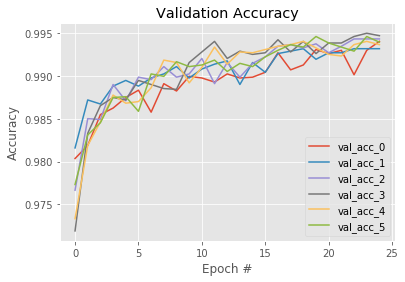

In [39]:
PlotLoss(histories, epochs, True)
PlotLoss(histories, epochs, False)
PlotAcc(histories, epochs, True)
PlotAcc(histories, epochs, False)

### 256 hidden layers looks promising, creating submission

In [40]:
preds = models[3].predict(X_pred)

In [41]:
pred_df['label'] = np.argmax(preds, axis=1)
preds = pred_df[['id', 'label']]
preds.to_csv('sub.csv', index=False)